## Setup

In [32]:
import haystack_utils
import math
import torch
import numpy as np
import seaborn as sns
from transformer_lens import HookedTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Plotly needs a different renderer for VSCode/Notebooks vs Colab
import plotly.io as pio
pio.renderers.default = "colab"  # "notebook_connected"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model and data loading

In [3]:
torch.autograd.set_grad_enabled(False)
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("pythia-70m-v0", fold_ln=True, device=device)

In [4]:
non_french = []
with open('kde4_english.txt', 'r') as f:
    non_french = f.readlines()

french = []
with open('kde4_french.txt', 'r') as f:
    french = f.readlines()

print(len(non_french), len(french))

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-v0 into HookedTransformer


## Sparse probing to rediscover the french neuron

In [19]:
french_acts = haystack_utils.get_mlp_activations(french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)
non_french_acts = haystack_utils.get_mlp_activations(non_french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)

# Balanced dataset of activations on french and non-french data
smaller_size = min(len(french_acts), len(non_french_acts))
A = torch.concat((french_acts[:smaller_size], non_french_acts[:smaller_size]), dim=0).cpu().numpy()
y = np.array([1]*smaller_size + [0]*smaller_size)

print(A.shape, y.shape)

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

(2014, 2048) (2014,)


In [21]:
def get_important_neurons(A_train: np.ndarray, y_train: np.ndarray, k: int):
    # score each activation dimension by the difference between the means of
    # the classes 0 and 1
    A_train, y_train = torch.Tensor(A_train), torch.Tensor(y_train)
    class_0_mean = A_train[y_train == 0].mean(dim=0)
    class_1_mean = A_train[y_train == 1].mean(dim=0)
    scores = (class_1_mean - class_0_mean).abs()
    top_k_scores, top_k_indices = torch.topk(scores, k)
    return top_k_indices, top_k_scores

In [22]:
# Get top classification neurons in A using class labels y
k = 10
test_accs = []
train_accs = []
for i in range(1):
    A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
    top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
    lr_model = LogisticRegression()
    topk = top_k_indices.cpu().numpy().tolist()
    print(topk)
    A_train = A_train[:, [730, 1856, 1600]]
    A_test = A_test[:, [730, 1856, 1600]]
    lr_model.fit(A_train, y_train)
    test_acc = lr_model.score(A_test, y_test)
    train_acc = lr_model.score(A_train, y_train)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

print(topk)
print(np.mean(train_accs))

[609, 705, 1361, 902, 102, 37, 588, 907, 1715, 1847]
[609, 705, 1361, 902, 102, 37, 588, 907, 1715, 1847]
0.6098233995584988


In [23]:
def get_top_individual_neuron_accuracy(k=10, n=5):
  test_accs = np.zeros((n, k))
  train_accs = np.zeros((n, k))
  for i in range(n):
      A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
      top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
      lr_model = LogisticRegression()
      topk = top_k_indices.cpu().numpy().tolist()
      for k_index, neuron in enumerate(topk):
          A_train_tmp = A_train[:, [neuron]]
          A_test_tmp = A_test[:, [neuron]]
          lr_model.fit(A_train_tmp, y_train)
          test_acc = lr_model.score(A_test_tmp, y_test)
          train_acc = lr_model.score(A_train_tmp, y_train)
          test_accs[i, k_index] = test_acc
          train_accs[i, k_index] = train_acc
  return train_accs, test_accs, topk


train_accs, test_accs, topk = get_top_individual_neuron_accuracy(n=20, k=50)

In [24]:
print(topk[:10])
print(train_accs.mean(0)[:10])

[609, 705, 1361, 902, 588, 102, 37, 1715, 907, 1847]
[0.93148455 0.67866998 0.77886313 0.65971302 0.80896799 0.72602097
 0.64919978 0.72392384 0.64983444 0.663383  ]


/tmp/ipykernel_21186/1142124930.py:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Individual neuron probe accuracy in MLP layer 3')

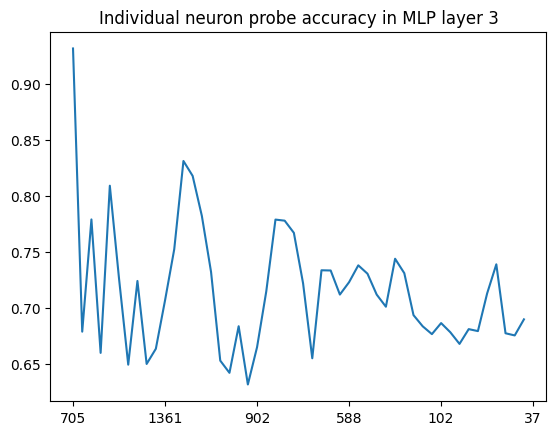

In [25]:
g = sns.lineplot(train_accs.mean(0))
g.set_xticklabels(topk)
g.set_title("Individual neuron probe accuracy in MLP layer 3")

In [26]:
top_k_indices, top_k_scores

(tensor([ 609,  705, 1361,  902,  102,   37,  588,  907, 1715, 1847]),
 tensor([2.4045, 0.7448, 0.6391, 0.6122, 0.5935, 0.5639, 0.5528, 0.5029, 0.4916,
         0.4770]))

## Test ablation performance

In [27]:
french_activation_L3N609 = french_acts[:, 609]
non_french_activation_L3N609 = non_french_acts[:, 609]
mean_french_activation_L3N609 = french_acts[:, 609].mean(0)
mean_non_french_activation_L3N609 = non_french_acts[:, 609].mean(0)
print("French activation:", mean_french_activation_L3N609.mean(0).item())
print("Non french activation:", mean_non_french_activation_L3N609.mean(0).item())

French activation: 2.3420770168304443
Non french activation: -0.06485679000616074


<Axes: ylabel='Count'>

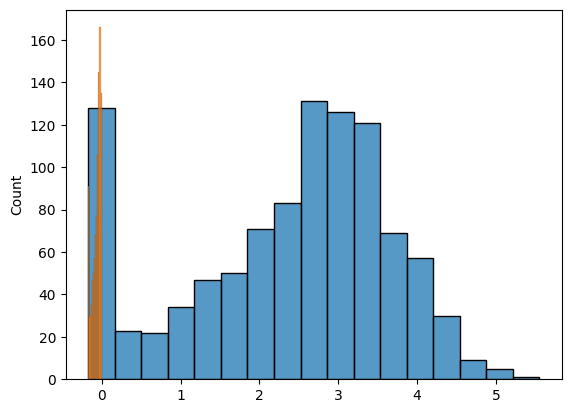

In [28]:
sns.histplot(french_activation_L3N609.cpu().numpy())
sns.histplot(non_french_activation_L3N609.cpu().numpy())

In [ ]:
act_label_l3 = f'blocks.3.mlp.hook_post'

In [29]:
def ablate_neuron_hook(value, hook):
  # Shape [batch pos d_mlp]
  #if hook.layer() == 3:
  value[:, :, 609] = mean_non_french_activation_L3N609
  return value

tokens = model.to_tokens(french[500:532])
print(tokens.shape)
original_loss = model(tokens, return_type="loss")
ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

print(f"Full model loss: {original_loss:.6f}")
print(f"Ablated MLP layer loss: {ablated_loss:.6f}")

torch.Size([32, 522])
Full model loss: 6.594291
Ablated MLP layer loss: 6.694891


In [35]:
# Summary Statistics for KDE dataset on Pythia
# average loss around 3
# loss increase from ablating french neuron around 6%

average_original_loss = 0
average_ablated_loss = 0

min_original_loss = math.inf
paired_ablated_loss = math.inf

for sample in french:
  tokens = model.to_tokens(sample)
  original_loss = model(tokens, return_type="loss")
  ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

  if (original_loss < min_original_loss):
    min_original_loss = original_loss
    paired_ablated_loss = ablated_loss
    min_original_loss = original_loss

  average_original_loss += original_loss
  average_ablated_loss += ablated_loss

average_original_loss /= len(french)
average_ablated_loss /= len(french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

print(f'{min_original_loss=}')
print(f'{paired_ablated_loss=}')

Full model loss: 3.576260
Ablated MLP layer loss: 3.800341
% increase: 6.265806
min_original_loss=tensor(0.8024, device='cuda:0')
paired_ablated_loss=tensor(0.8012, device='cuda:0')


### Loss from disabling/enabling the neuron on non-French text

In [37]:
# Loss from disabling French neuron on non-French text - if this is high it disproves that the neuron is only relevant to non-French text (although it could be 
# due to French loanwords)
# It's very low

def enable_neuron_hook(value, hook):
  # Shape [batch pos d_mlp]
  #if hook.layer() == 3:
  value[:, :, 609] = mean_french_activation_L3N609
  return value


average_original_loss = 0
average_ablated_loss = 0

for sample in non_french:
  tokens = model.to_tokens(sample)
  average_original_loss += model(tokens, return_type="loss")
  average_ablated_loss +=  model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

average_original_loss /= len(non_french)
average_ablated_loss /= len(non_french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

# Loss from enabling French neuron on non-French text - if this is high it shows that the neuron is influential on its own, not just as part of a circuit
# which we can discover. E.g., there's an unembedding direction which "translates" words and this neuron triggers it.

average_original_loss = 0
average_ablated_loss = 0

for sample in non_french:
  tokens = model.to_tokens(sample)
  average_original_loss += model(tokens, return_type="loss")
  average_ablated_loss +=  model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, enable_neuron_hook)])

average_original_loss /= len(non_french)
average_ablated_loss /= len(non_french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

Full model loss: 3.860954
Ablated MLP layer loss: 3.861081
% increase: 0.003298
Full model loss: 3.860954
Ablated MLP layer loss: 3.937044
% increase: 1.970765
